# Import Library

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
from collections import Counter

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Deep Learning
from gensim.models import FastText
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import cross_val_score

# Hyperparameter Tuning
from keras_tuner import RandomSearch

# Model Performance
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preparation

In [2]:
file_path = r"..\Pre_Hate_Dataset\20_Hate_Final.csv"
data = pd.read_csv(file_path)

X = data['text'].astype(str).values  
Y = data['label'].values  
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

# Word Embedding
max_words = 20000  # vocab size
max_len = 100  # the max length of the each sentences 

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X) 
X_seq = tokenizer.texts_to_sequences(X) 
X_padding = pad_sequences(X_seq, maxlen=max_len)  #Filling text sequences of different lengths (padding)

# Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X_padding, Y, test_size=0.3, stratify=Y, random_state=42)
print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)
print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)

# Undersampling
print("Class distribution before resampling:", Counter(Y))
undersampler = RandomUnderSampler(random_state=42)
x_train_resampled, y_train_resampled = undersampler.fit_resample(X_train,Y_train)

print("Class distribution after resampling:", Counter(y_train_resampled))
print(f"Number of training samples after resampling: {x_train_resampled.shape[0]}")
 


X_train shape (57447, 100)
Y_train shape (57447,)
X_test shape (24621, 100)
Y_test shape (24621,)
Class distribution before resampling: Counter({0: 56264, 1: 25804})
Class distribution after resampling: Counter({0: 18063, 1: 18063})
Number of training samples after resampling: 36126


# Bi-GRU Base Model

In [ ]:
MAX_SEQUENCE_LENGTH = 100  
EMBEDDING_DIM = 300
MAX_VOCAB_SIZE = 200000

# https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(GRU(128, return_sequences=True)),  
    Bidirectional(GRU(64, return_sequences=False)), 
    Dense(32, activation='tanh'), 
    Dense(1, activation='sigmoid') 
])

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(),  # Default Learning Rate: 0.001
    metrics=["accuracy"]
)

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    x_train_resampled,
    y_train_resampled,
    epochs=10,  
    batch_size=32,
    validation_data=(X_test, Y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluete Model -------------------------------------------------------------------------------------------------
train_loss, train_accuracy = model.evaluate(x_train_resampled, y_train_resampled, verbose=1)
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(Y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

precision = precision_score(Y_test, y_pred, average='binary') 
recall = recall_score(Y_test, y_pred, average='binary')

print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌 Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))

# Save model -------------------------------------------------------------------------------------------------
model.save("BiGRU_Default_Model.h5")
joblib.dump(history.history, "BiGRU_Default_History.pkl")
print("Model saved successfully!")

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 755s 657ms/step - accuracy: 0.7272 - loss: 0.5269 - val_accuracy: 0.7727 - val_loss: 0.4478
Epoch 2/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 714s 633ms/step - accuracy: 0.8520 - loss: 0.3406 - val_accuracy: 0.7800 - val_loss: 0.4438
Epoch 3/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 750s 664ms/step - accuracy: 0.8892 - loss: 0.2603 - val_accuracy: 0.7749 - val_loss: 0.4968
Epoch 4/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 795s 704ms/step - accuracy: 0.9168 - loss: 0.1942 - val_accuracy: 0.7638 - val_loss: 0.6136
Epoch 5/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 825s 731ms/step - accuracy: 0.9412 - loss: 0.1400 - val_accuracy: 0.7525 - val_loss: 0.7007
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 47s 41ms/step - accuracy: 0.8580 - loss: 0.2701
770/770 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.7813 - loss: 0.4446
770/770 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step



📌 Train Accuracy: 0.8942
📌 Test Accuracy: 0.7800

📌 Weighted F1 Score: 0.7874
📌 Precision: 0.6049
📌 Recall: 0.8658

📌 Test ROC AUC: 0.8774

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82     16880
           1       0.60      0.87      0.71      7741

    accuracy                           0.78     24621
   macro avg       0.76      0.80      0.77     24621
weighted avg       0.82      0.78      0.79     24621


📌 Confusion Matrix:
[[12502  4378]
 [ 1039  6702]]
Model saved successfully!


In [ ]:
from tensorflow.keras.models import load_model

model = load_model(r"Saved Model Hate/GRU/BiGRU_Default_Model.h5")

train_loss, train_accuracy = model.evaluate(x_train_resampled, y_train_resampled, verbose=1)
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(Y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y_test, y_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y_test, y_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(Y_test, y_pred, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(Y_test, y_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))


1129/1129 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - accuracy: 0.8580 - loss: 0.2701
770/770 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.7813 - loss: 0.4446
770/770 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step

📌 Train Accuracy: 0.8942
📌 Test Accuracy: 0.7800

📌 Weighted F1 Score: 0.7874
📌 Micro F1 Score: 0.7800
📌 Macro F1 Score: 0.7671

📌 Precision: 0.6049
📌 Recall: 0.8658

📌Test ROC AUC: 0.8774

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82     16880
           1       0.60      0.87      0.71      7741

    accuracy                           0.78     24621
   macro avg       0.76      0.80      0.77     24621
weighted avg       0.82      0.78      0.79     24621


📌 Confusion Matrix:
[[12502  4378]
 [ 1039  6702]]


## Confusion Matrix

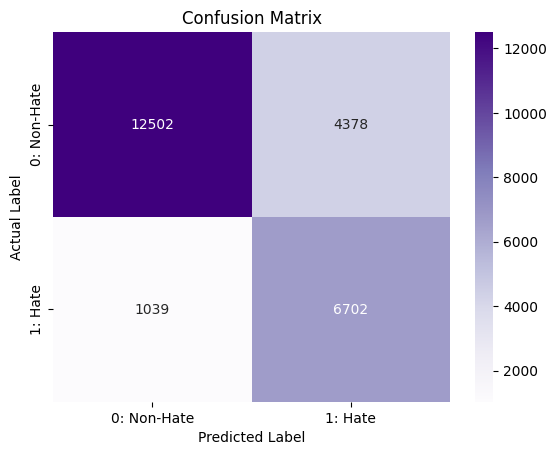

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred)

# annot & fmt: Display decimal values 
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=['Non-Hate', 'Hate'], 
            yticklabels=['Non-Hate', 'Hate'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()



## Learning Curve

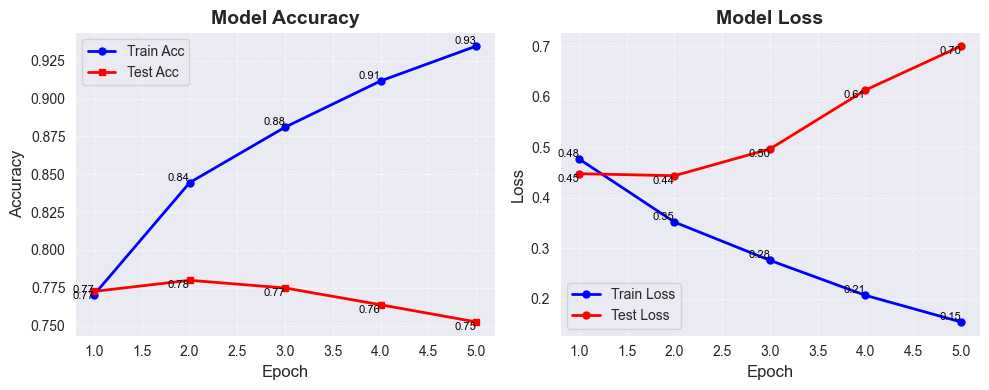

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1 )

sns.set_style("darkgrid") 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Test Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.2f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Test Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.2f}", ha='right', va='top', fontsize=8, color='black')

plt.tight_layout()
plt.show()


## ROC_AUC


📌 ROC AUC: 0.8774


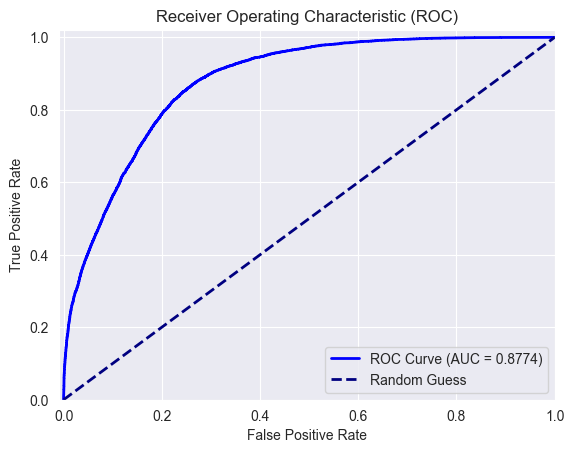

In [18]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## precision_recall_curve


📌 Precision-Recall AUC: 0.7536


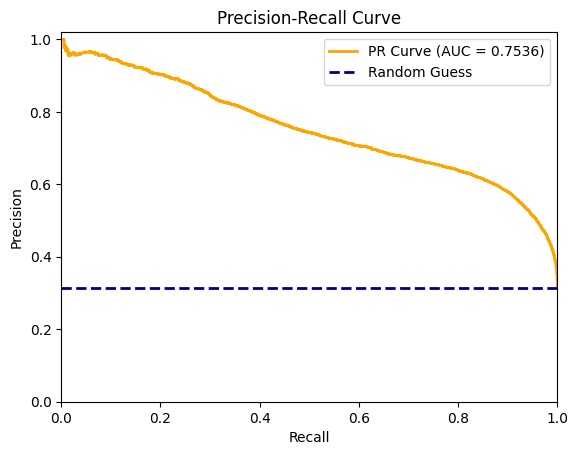

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(Y_test, y_pred_prob)
pr_auc = average_precision_score(Y_test, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='orange', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_test) / len(Y_test)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


# Bi-GRU HP Tuning (FastText)

In [ ]:
MAX_SEQUENCE_LENGTH = 100  
EMBEDDING_DIM = 300
max_words = 20000  

# ---------------------------------------------------------------------------------------------------------------------

file_path = r"../Pre_Hate_Dataset/20_Hate_Final.csv"
df = pd.read_csv(file_path)

texts = df['text'].astype(str).values 
labels = df['label'].values 

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts) 
X_seq = tokenizer.texts_to_sequences(texts) 
X_padding = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LENGTH)  #Filling text sequences of different lengths (padding)

X_train, X_test, Y_train, Y_test = train_test_split(X_padding, y, test_size=0.3, stratify=y, random_state=42)

# Undersampling
undersampler = RandomUnderSampler(random_state=42)
x_train_resampled, y_train_resampled = undersampler.fit_resample(X_train,Y_train)
print("Class distribution after resampling:", Counter(y_train_resampled))

# ---------------------------------------------------------------------------------------------------------------------

MAX_VOCAB_SIZE = len(tokenizer.word_index) + 1  

# https://fasttext.cc/docs/en/english-vectors.html 
fasttext_path = "crawl-300d-2M-subword.bin" 
word_vectors = FastText.load_fasttext_format(fasttext_path)

embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB_SIZE:
        if word in word_vectors.wv:
            embedding_matrix[i] = word_vectors.wv[word]
        else:
            embedding_matrix[i] = np.random.normal(size=(EMBEDDING_DIM,))   

embedding_layer = Embedding(
    input_dim=MAX_VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False  
)

def build_model(hp):
    model=Sequential()
    model.add(embedding_layer)

    model.add(Bidirectional(GRU(units=hp.Int("GRU_layer_1", min_value=64, max_value=256, step=64),return_sequences=True)))
    model.add(Dropout(hp.Float("dropout_1", min_value=0.2, max_value=0.4, step=0.1)))

    model.add(Bidirectional(GRU(units=hp.Int("GRU_layer_2", min_value=32, max_value=128, step=32), return_sequences=True )))
    model.add(Dropout(hp.Float("dropout_2", min_value=0.2, max_value=0.4, step=0.1)))

    model.add(Bidirectional(GRU(units=hp.Int("GRU_layer_3", min_value=16, max_value=64, step=32), return_sequences=False )))
    model.add(Dropout(hp.Float("dropout_3", min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(units=hp.Int("dense_units", min_value=16, max_value=64, step=16), 
                    activation=hp.Choice("activation", ["relu", "tanh","sigmoid"]),  
                    kernel_regularizer=tf.keras.regularizers.l2(hp.Float("l2_reg", min_value=0.001, max_value=0.1, step=0.01))))
    # output
    model.add(Dense(1, activation="sigmoid"))

    # Momentum = SGD + Mini-batch
    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd', 'adagrad'])
    learning_rate = hp.Choice("learning_rate", [0.0001, 0.003, 0.01, 0.3])

    if optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)

    model.compile(
        optimizer = optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials=10,
                    executions_per_trial=1,
                    directory='my_dir_GRU_Hate',
                    project_name='hyperparam_tuning_LSTM_4_FastText')

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

tuner.search(x_train_resampled,y_train_resampled,epochs=10,batch_size=32,validation_data=(X_test,Y_test), callbacks=[early_stopping])

best_model = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""Best Hyperparameter:
        Bi-GRU  Layer 1: {best_model.get('GRU_layer_1')}
        Bi-GRU  Layer 2: {best_model.get('GRU_layer_2')}
        Bi-GRU  Layer 3: {best_model.get('GRU_layer_3')}
        Dropout 1: {best_model.get('dropout_1')}
        Dropout 2: {best_model.get('dropout_2')}
        Dropout 3: {best_model.get('dropout_3')}
        Dense : {best_model.get('dense_units')}
        Learning Rate : {best_model.get('learning_rate')}
        Optimizer Choice: {best_model.get('optimizer')}
        """)

model = build_model(best_model)
history = model.fit(x_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

# Evaluate Model ---------------------------------------------------------------------------------------------------------------------

train_loss, train_accuracy = model.evaluate(x_train_resampled, y_train_resampled, verbose=1)
print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")

test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

f1_weighted = f1_score(Y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y_test, y_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y_test, y_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(Y_test, y_pred, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(Y_test, y_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))


# Save Model ---------------------------------------------------------------------------------------------------------------------

joblib.dump(tuner, "4_GRU_Hate_HPTuner_FastTExt.pkl")
model.save("4_GRU_Hate_HP_FastText.h5") 
joblib.dump(history.history, "4_GRU_Hate_HP_history_FastText.pkl")
print("Model saved successfully!")



Trial 10 Complete [00h 15m 46s]
val_accuracy: 0.6855936050415039

Best val_accuracy So Far: 0.8115429878234863
Total elapsed time: 05h 37m 10s
Best Hyperparameter:
Bi-GRU  Layer 1: 128
Bi-GRU  Layer 2: 32
Bi-GRU  Layer 3: 16
Dropout 1: 0.2
Dropout 2: 0.4
Dropout 3: 0.2
Dense : 16
Learning Rate : 0.003
Optimizer Choice: adam

Epoch 1/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 305s 231ms/step - accuracy: 0.7382 - loss: 0.7313 - val_accuracy: 0.7790 - val_loss: 0.4665
Epoch 2/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 249s 219ms/step - accuracy: 0.8010 - loss: 0.4601 - val_accuracy: 0.7743 - val_loss: 0.4883
Epoch 3/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 211s 187ms/step - accuracy: 0.8155 - loss: 0.4330 - val_accuracy: 0.8020 - val_loss: 0.4223
Epoch 4/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 249s 220ms/step - accuracy: 0.8216 - loss: 0.4178 - val_accuracy: 0.7994 - val_loss: 0.4213
Epoch 5/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 255s 226ms/step - accuracy: 0.8301 - loss: 0.3989 - val_accuracy: 0.7694 - val_loss: 0.4972
Epo

Model saved successfully!


## Evaluate

In [39]:
print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(Y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y_test, y_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y_test, y_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(Y_test, y_pred, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(Y_test, y_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))


📌 Train Accuracy: 0.8543
📌 Test Accuracy: 0.7797

📌 Weighted F1 Score: 0.7872
📌 Micro F1 Score: 0.7797
📌 Macro F1 Score: 0.7671

📌 Precision: 0.6039
📌 Recall: 0.8702

📌Test ROC AUC: 0.8809

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82     16880
           1       0.60      0.87      0.71      7741

    accuracy                           0.78     24621
   macro avg       0.76      0.80      0.77     24621
weighted avg       0.82      0.78      0.79     24621


📌 Confusion Matrix:
[[12461  4419]
 [ 1005  6736]]


## Learning Curve

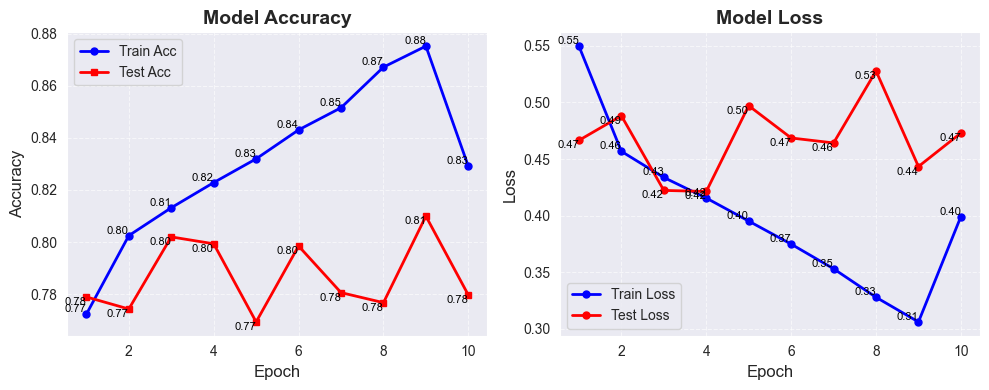

In [ ]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

sns.set_style("darkgrid") 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Test Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.2f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Test Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.2f}", ha='right', va='top', fontsize=8, color='black')

plt.tight_layout()
plt.show()


## ROC_AUC


📌 ROC AUC: 0.8809


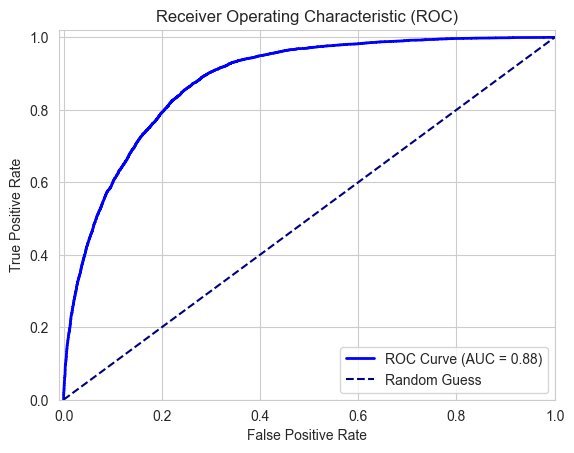

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## precision_recall_curve


📌 Precision-Recall AUC: 0.7567


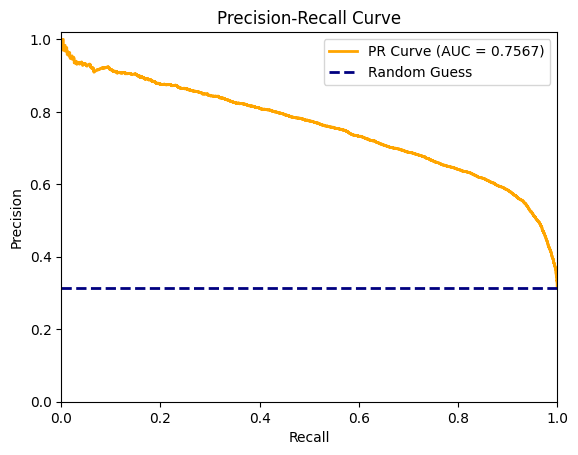

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(Y_test, y_pred_prob)
pr_auc = average_precision_score(Y_test, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='orange', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_test) / len(Y_test)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


## Confusion Matrix

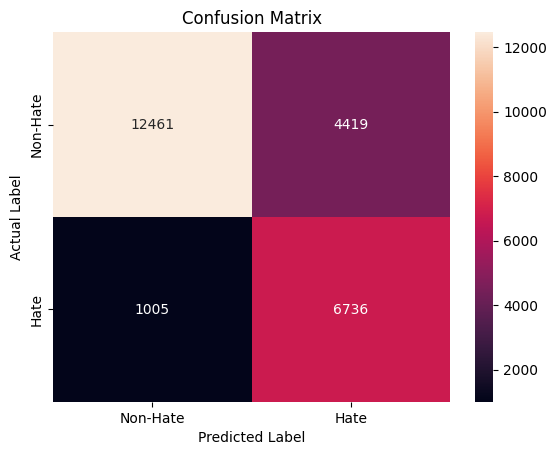

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=['Non-Hate', 'Hate'], 
            yticklabels=['Non-Hate', 'Hate'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()



# Fine Tuning

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.saving import register_keras_serializable

# ---------------------------------------------------------------------------------------------------------------------
MAX_SEQUENCE_LENGTH = 100  
EMBEDDING_DIM = 300
max_words = 20000  

# ---------------------------------------------------------------------------------------------------------------------

file_path = r"../Pre_Hate_Dataset/20_Hate_Final.csv"
df = pd.read_csv(file_path)

texts = df['text'].astype(str).values 
labels = df['label'].values 

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts) 
X_seq = tokenizer.texts_to_sequences(texts) 
X_padding = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LENGTH)  #Filling text sequences of different lengths (padding)

X_train, X_test, Y_train, Y_test = train_test_split(X_padding, y, test_size=0.3, stratify=y, random_state=42)

# Undersampling
undersampler = RandomUnderSampler(random_state=42)
x_train_resampled, y_train_resampled = undersampler.fit_resample(X_train,Y_train)
print("Class distribution after resampling:", Counter(y_train_resampled))

# ---------------------------------------------------------------------------------------------------------------------
MAX_VOCAB_SIZE = len(tokenizer.word_index) + 1  

# https://fasttext.cc/docs/en/english-vectors.html 
fasttext_path = "crawl-300d-2M-subword.bin" 
word_vectors = FastText.load_fasttext_format(fasttext_path)
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB_SIZE:
        if word in word_vectors.wv:
            embedding_matrix[i] = word_vectors.wv[word]
        else:
            embedding_matrix[i] = np.random.normal(size=(EMBEDDING_DIM,))   

embedding_layer = Embedding(
    input_dim=MAX_VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False  
)

def build_model():
    model = Sequential()
    model.add(embedding_layer)

    model.add(Bidirectional(GRU(units=128, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(Bidirectional(GRU(units=32, return_sequences=True)))
    model.add(Dropout(0.4))

    model.add(Bidirectional(GRU(units=16, return_sequences=False)))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dense(1, activation="sigmoid"))

    optimizer = Adam(learning_rate=0.003)

    @register_keras_serializable(package="CustomLoss")
    def focal_loss(gamma=2.0, alpha=0.53):
        def focal_loss_1(y_true, y_pred): 
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
            pt = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred) # Predicted probability of the correct class
            alpha_factor = K.ones_like(y_true)*alpha # Alpha factor for balancing class imbalance. 
            alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)  # Dynamically assigns different alpha values to different classes
            cross_entropy = -K.log(pt) # Cross-entropy loss
            # Alpha > 0.5, then class 1 weigth > class 0 weigth. Alpha < 0.5, then class 0 weigth > class 1 weigth
            weight = alpha_t * K.pow((1-pt), gamma) #alpha_t*(1 - pt) ^ gamma
            loss = weight * cross_entropy
            loss = K.mean(loss, axis=1)
            return loss
        return focal_loss_1

    model.compile(optimizer=optimizer, loss=focal_loss(), metrics=['accuracy'])
    return model

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.5,           # Decrease LR (current LR * 0.5)
    patience=1,           # If val_loss does not improve for 1 epoch, reduce LR
    min_lr=0.0001,        # Setting minimum learning rate to prevent it from being too low
    verbose=1             
)
early_stopping = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

model = build_model()
history = model.fit(x_train_resampled, y_train_resampled, epochs=10, batch_size=32, 
                    validation_data=(X_test, Y_test), callbacks=[early_stopping,reduce_lr])

model.save("6_GRU_Hate_FineTuning_Model.keras") 
joblib.dump(history.history, "6_GRU_Hate_FineTuning_History.pkl")
print("Model saved successfully!")

Class distribution after resampling: Counter({0: 18063, 1: 18063})


C:\Users\Asus\AppData\Local\Temp\ipykernel_17484\1912965453.py:38: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  word_vectors = FastText.load_fasttext_format(fasttext_path)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 162s 134ms/step - accuracy: 0.7256 - loss: 0.0727 - val_accuracy: 0.7703 - val_loss: 0.0607 - learning_rate: 0.0030
Epoch 2/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7965 - loss: 0.0581
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 141s 125ms/step - accuracy: 0.7965 - loss: 0.0581 - val_accuracy: 0.7456 - val_loss: 0.0644 - learning_rate: 0.0030
Epoch 3/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 145s 128ms/step - accuracy: 0.8098 - loss: 0.0548 - val_accuracy: 0.7993 - val_loss: 0.0539 - learning_rate: 0.0015
Epoch 4/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8210 - loss: 0.0520
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.000750000006519258.
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 146s 129ms/step - accuracy: 0.8210 - loss: 0.0520 - val_accuracy: 0.7867 - val_loss: 0.0546 - learning_rate: 0.0015
Epoch 5/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - ac

## Evaluate

In [4]:
# Evaluate model
train_loss, train_accuracy = model.evaluate(x_train_resampled, y_train_resampled, verbose=1)
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(Y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y_test, y_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y_test, y_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(Y_test, y_pred, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(Y_test, y_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))

1129/1129 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - accuracy: 0.8087 - loss: 0.0490
770/770 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.7984 - loss: 0.0546
770/770 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step

📌 Train Accuracy: 0.8283
📌 Test Accuracy: 0.7993

📌 Weighted F1 Score: 0.8054
📌 Micro F1 Score: 0.7993
📌 Macro F1 Score: 0.7841

📌 Precision: 0.6353
📌 Recall: 0.8490

📌Test ROC AUC: 0.8865

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84     16880
           1       0.64      0.85      0.73      7741

    accuracy                           0.80     24621
   macro avg       0.78      0.81      0.78     24621
weighted avg       0.83      0.80      0.81     24621


📌 Confusion Matrix:
[[13108  3772]
 [ 1169  6572]]


##  Confusion Matrix

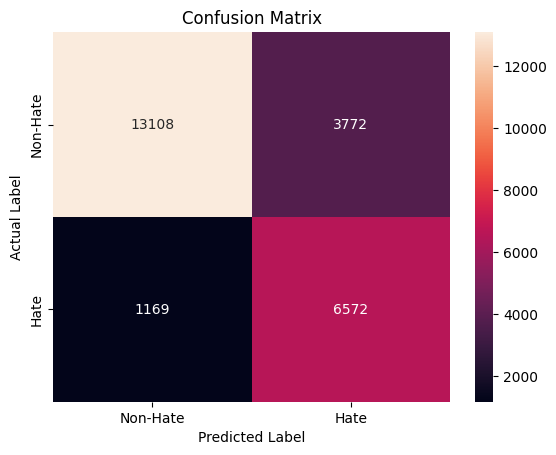

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred)

# annot & fmt: Display decimal values 
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=['Non-Hate', 'Hate'], 
            yticklabels=['Non-Hate', 'Hate'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()



## Learning Curve

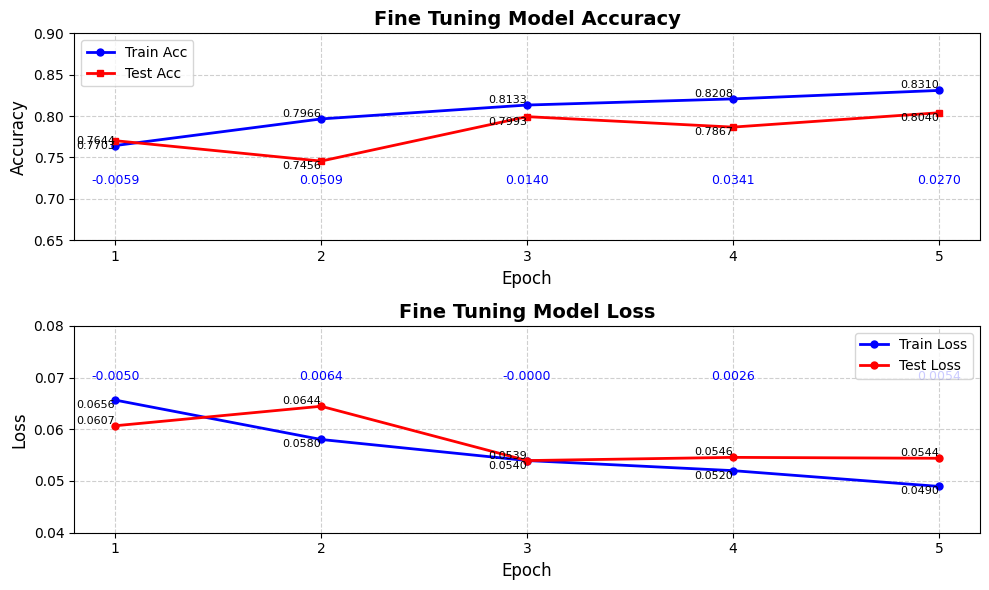

In [ ]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Test Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Fine Tuning Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)

# backgroud column grid
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Test Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Fine Tuning Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.4f}", ha='right', va='top', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')

axes[0].set_xticks(range(1, len(epochs) + 1, 1)) 
axes[1].set_xticks(range(1, len(epochs) + 1, 1))  

acc_diff = [round(accuracy[i] - val_acc[i], 4) for i in range(len(accuracy))]
loss_diff = [round(val_loss[i] - loss[i] , 4) for i in range(len(loss))]

# Display the difference between Train and Test
for i in range(len(epochs)):
    axes[0].text(epochs[i], min(accuracy) -0.05, f"{acc_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
    axes[1].text(epochs[i], min(loss) +0.02, f"{loss_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')

axes[0].set_ylim(0.65, 0.9)
axes[1].set_ylim(0.04, 0.08)

plt.tight_layout()
plt.show()



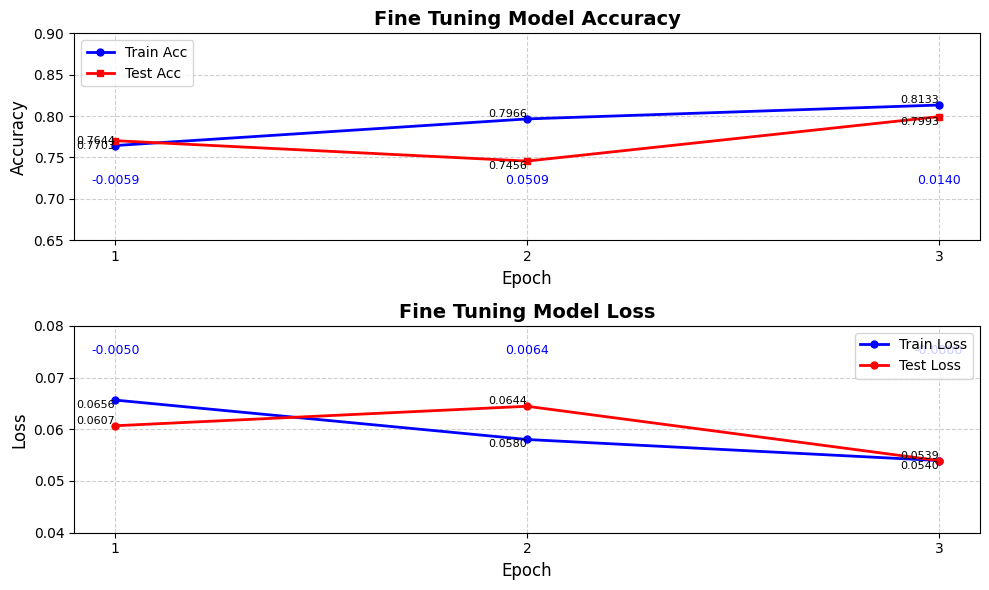

In [ ]:
accuracy = history.history['accuracy'][:3]
val_acc = history.history['val_accuracy'][:3]
loss = history.history['loss'][:3]
val_loss = history.history['val_loss'][:3]

epochs = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Test Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Fine Tuning Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)

# backgroud column grid
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Test Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Fine Tuning Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.4f}", ha='right', va='top', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')

axes[0].set_xticks(range(1, len(epochs) + 1, 1)) 
axes[1].set_xticks(range(1, len(epochs) + 1, 1))  

acc_diff = [round(accuracy[i] - val_acc[i], 4) for i in range(len(accuracy))]
loss_diff = [round(val_loss[i] - loss[i] , 4) for i in range(len(loss))]

# Display the difference between Train and Test
for i in range(len(epochs)):
    axes[0].text(epochs[i], min(accuracy) -0.05, f"{acc_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
    axes[1].text(epochs[i], min(loss) +0.02, f"{loss_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')

axes[0].set_ylim(0.65, 0.9)
axes[1].set_ylim(0.04, 0.08)

plt.tight_layout()
plt.show()



## precision_recall_curve


📌 Precision-Recall AUC: 0.7627


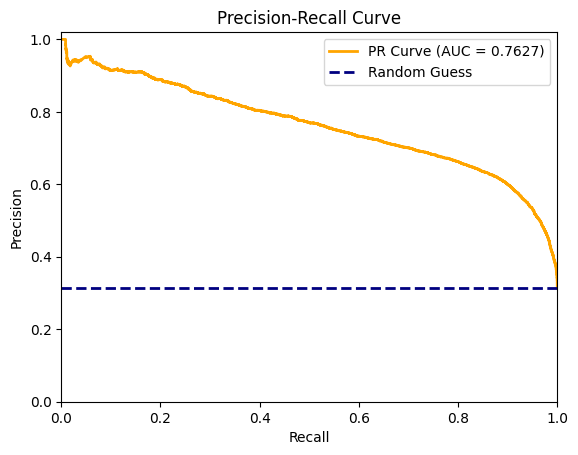

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(Y_test, y_pred_prob)
pr_auc = average_precision_score(Y_test, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='orange', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_test) / len(Y_test)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


## ROC-AUC


📌 ROC AUC: 0.8865


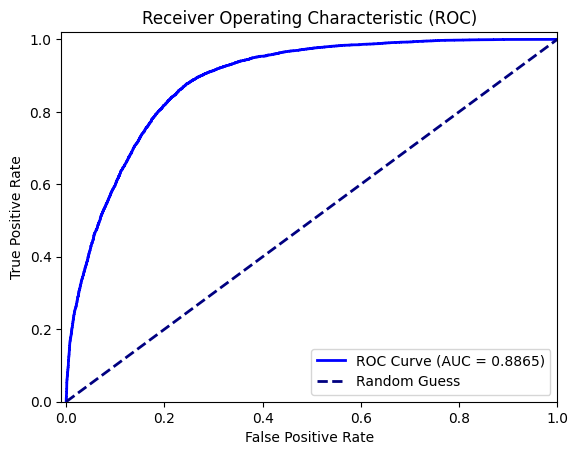

In [12]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
